Compute the loss in optical efficiency when the Feedhorn F/# does not match the optics F/#. This is done as a function of wavelength too, assuming a conical horn whose aperture illumination is specified in Goldsmith.

In [2]:
import numpy as np
import numpy.polynomial.polynomial as poly
import matplotlib.pyplot as plt
import scipy.special as sps
import warnings

In [93]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

# Approximate aperture field distribution of a corrugated conical feedhorn given by
# Goldsmith Eq. 7.36 for y-directed linear polarization.
def corrugated_feed_field(r,a,R,wavelength):
    field = sps.j0(2.405*r/a)*np.exp(-1j*np.pi*np.power(r,2)/(wavelength*R))
    field[r > a] = 0
    return field

# Aperture field distribution of a conical smooth walled horn given by 
# Goldsmith Eq. 7.46a for the y-polarized component, for which 96% couples into.
def conical_feed_field(x,y,a,R,wavelength):
    u = 1.841
    rho,phi = cart2pol(x,y)
    mask = rho==0
    field = np.zeros(np.shape(rho))
    field[mask] = 0.5*sps.j0(u*rho[mask]/a)
    field[~mask] = (sps.j1(u*rho[~mask]/a)/(u*rho[~mask]/a)*np.power(np.sin(phi[~mask]),2)
                    + sps.jvp(1,u*rho[~mask]/a,1)*np.power(np.cos(phi[~mask]),2))
    field = field * np.exp(-1j*np.pi*np.power(rho,2)/(wavelength*R))
    field[rho > a] = 0
    return field

def CTF(z, wavelength, xi, eta):
    gamma = np.sqrt((1/np.power(wavelength,2) - (np.power(xi,2) + np.power(eta,2)))+0j)
    return np.exp(1j*2*np.pi*gamma*z)

# Angular spectrum propagation. The propagated field is evaluated at a z plane, on the 2D coordinates x,y.
def ASP(delta_x, delta_y, field, z0, wavelength):
    # 2D Fourier transform of the input field results in the angular spectrum
    A = np.fft.fft2(field)
    
    # Shift the frequencies to be centered on zero
    A_shift = np.fft.fftshift(A)
    
    # Multiply by transfer function of free space to propagate the spectrum
    xi = np.linspace(-1/(2*delta_x), 1/(2*delta_x), field.shape[1])
    eta = np.linspace(-1/(2*delta_y), 1/(2*delta_y), field.shape[0])
    Xi,Eta = np.meshgrid(xi, eta, sparse=False, indexing='xy')
    A_prop = A_shift * CTF(z0, wavelength, Xi, Eta)
    
    # Shift the frequencies back
    A_shift = np.fft.ifftshift(A_prop)
    
    # 2D inverse Fourier transform the spectrum to obtain the physical field
    return np.fft.ifft2(A_shift)

def jinc(r):
    coords = np.array(r)
    mask = coords==0
    output = 0.5*np.ones(np.shape(coords))
    output[~mask] = sps.j1(coords[~mask])/coords[~mask]
    return output

# Field distribution from diffraction due to an elliptical aperture, given by
# Far-Field Radiation Patterns of Ellipitcal Apertures and Its Annulli by Y.P. Kathuria
# Eq. 4. f is the focal length of the system, 2a, 2b are the major and minor diameter
# of the elliptical aperture.
def elliptical_diffract_field(x,y,f,wavelength,a,b):
    k = 2*np.pi/wavelength
    C = np.exp(1j*k*f)/(1j*wavelength*f)*np.exp(1j*k/(2*f)*(x*x + y*y))
    epsilon = b/a
    K = k*epsilon*a*np.sqrt(x*x/(epsilon**2) + y*y)/f
    return 2*np.pi*epsilon*a*a*jinc(K) #2*np.pi*epsilon*a*a*C*jinc(K)

def fit_chromatic_res(w1,w2,f,TFNO,SFNO,fit_wavs):
    T_coeffs = poly.polyfit(np.linspace(w1,w2,len(TFNO)), TFNO, 2)
    S_coeffs = poly.polyfit(np.linspace(w1,w2,len(SFNO)), SFNO, 2)
    a_SW = f/(2*poly.polyval(fit_wavs, T_coeffs))
    b_SW = f/(2*poly.polyval(fit_wavs, S_coeffs))
    return (a_SW, b_SW)

### Feed Horn Parameters

In [97]:
# Feedhorn aperture radius
a = 1

# aperture coordinates
min_x = -2*a
max_x = 2*a
min_y = -2*a
max_y = 2*a
x_ap = np.linspace(min_x, max_y, 51)
y_ap = np.linspace(min_y, max_y, 51)
delta_x = x_ap[1] - x_ap[0]
delta_y = y_ap[1] - y_ap[0]
X_ap,Y_ap = np.meshgrid(x_ap, y_ap, sparse=False, indexing='xy')
r = np.sqrt(X_ap*X_ap + Y_ap*Y_ap)

# "focal length" (distance between exit pupil and observation plane).
# Set to 1 so we can just use the 1/(2*F/#) as the aperture radius.
f = 1

# Wavelength bands
SW1 = 240
SW2 = 317
LW1 = 317
LW2 = 420
numWavs = 72
wavs_SW = np.linspace(SW1,SW2,numWavs)
wavs_LW = np.linspace(LW1,LW2,numWavs)

# Feedhorn slant length a.k.a radius of curvature
R = 4.73

# Optimal defocusing distance
delta_z = 0

### Analytic Coupling

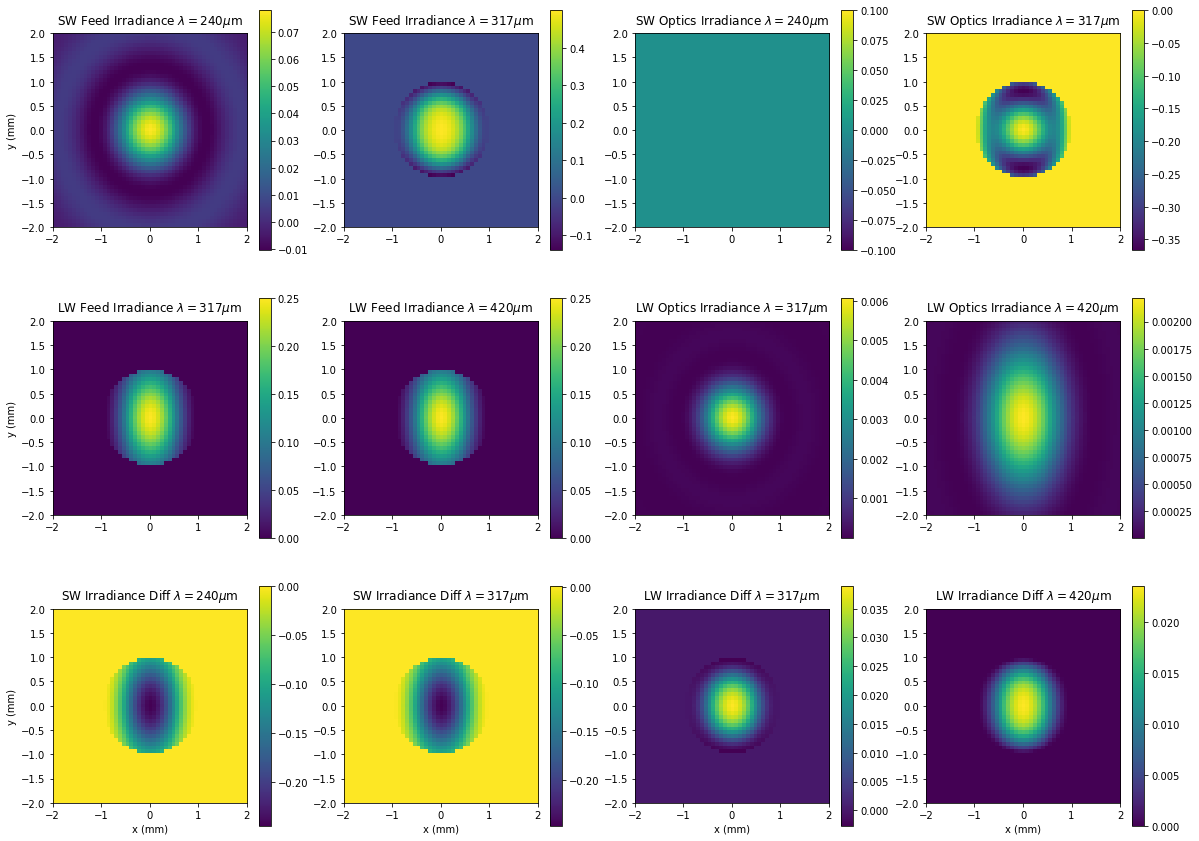

In [98]:
fig, ((ax_SW_feed_minW, ax_SW_feed_maxW, ax_SW_optics_minW, ax_SW_optics_maxW),
      (ax_LW_feed_minW, ax_LW_feed_maxW, ax_LW_optics_minW, ax_LW_optics_maxW),
      (ax_SW_diff_minW, ax_SW_diff_maxW, ax_LW_diff_minW, ax_LW_diff_maxW)) = plt.subplots(3,4,figsize=(20,15))

ax_SW_feed_minW.set_title('SW Feed Irradiance $\lambda={}\mu$m'.format(SW1))
ax_SW_feed_maxW.set_title('SW Feed Irradiance $\lambda={}\mu$m'.format(SW2))
ax_SW_optics_minW.set_title('SW Optics Irradiance $\lambda={}\mu$m'.format(SW1))
ax_SW_optics_maxW.set_title('SW Optics Irradiance $\lambda={}\mu$m'.format(SW2))
ax_SW_diff_minW.set_title('SW Irradiance Diff $\lambda={}\mu$m'.format(SW1))
ax_SW_diff_maxW.set_title('SW Irradiance Diff $\lambda={}\mu$m'.format(SW2))

ax_LW_feed_minW.set_title('LW Feed Irradiance $\lambda={}\mu$m'.format(LW1))
ax_LW_feed_maxW.set_title('LW Feed Irradiance $\lambda={}\mu$m'.format(LW2))
ax_LW_optics_minW.set_title('LW Optics Irradiance $\lambda={}\mu$m'.format(LW1))
ax_LW_optics_maxW.set_title('LW Optics Irradiance $\lambda={}\mu$m'.format(LW2))
ax_LW_diff_minW.set_title('LW Irradiance Diff $\lambda={}\mu$m'.format(LW1))
ax_LW_diff_maxW.set_title('LW Irradiance Diff $\lambda={}\mu$m'.format(LW2))

ax_LW_diff_minW.set_xlabel('x (mm)')
ax_SW_diff_minW.set_xlabel('x (mm)')
ax_LW_diff_maxW.set_xlabel('x (mm)')
ax_SW_diff_maxW.set_xlabel('x (mm)')

ax_SW_feed_minW.set_ylabel('y (mm)')
ax_LW_feed_minW.set_ylabel('y (mm)')
ax_SW_diff_minW.set_ylabel('y (mm)')

# Assume F/# varies linearly across band and is constant in spatial direction.
sw_fnum_spatial = 3 * np.ones(numWavs);
sw_fnum_spectral = np.linspace(3.36, 5.56, numWavs);

lw_fnum_spatial = 3 * np.ones(numWavs);
lw_fnum_spectral = np.linspace(3.36, 5.56, numWavs);

# Calculate the aperture half size that results in the desired F/# for a 'focal length' of 1.
sw_a = f/(2*sw_fnum_spatial);
sw_b = f/(2*sw_fnum_spectral);

lw_a = f/(2*lw_fnum_spatial);
lw_b = f/(2*lw_fnum_spectral);

# Multiply fields, compute irradiance, compute power, normalize by power in corrugated feed field.
coupling_SW = np.empty(numWavs)
coupling_LW = np.empty(numWavs)

for w in range(numWavs):
    # Convert wavelength from microns to mm.
    # Use Angular Spectrum Propagation to calculate the feed horn field at the optimial defocusing distance for z != 0.
    if delta_z != 0:
        feed_field = ASP(delta_x, delta_y, conical_feed_field(X_ap,Y_ap,a,R,wavs_SW[w]/1000), delta_z, wavs_SW[w]/1000)
        # Mask the feed field according to how far into the aperture it propagated.
        mask = np.sqrt(X_ap**2 + Y_ap**2) > a/R*(R-delta_z)
        feed_field[mask] = 0
    else:
        feed_field = conical_feed_field(X_ap,Y_ap,a,R,wavs_SW[w]/1000)

    # Compute the field generated by the telescope.
    optics_field = elliptical_diffract_field(X_ap,Y_ap,f,wavs_SW[w]/1000,sw_a[w],sw_b[w])

    # Compute the coupling integral between the optics and feed at the optimal defocusing distance.
    coupling = np.sum(np.sum(optics_field*np.conj(feed_field)))/np.sqrt(np.sum(np.sum((optics_field*np.conj(optics_field))))
                                                                *np.sum(np.sum((feed_field*np.conj(feed_field)))))
    coupling_SW[w] = (coupling*np.conj(coupling)).real

    # Just plot the images at the ends of the bands to check.
    if w == 0:
        im = ax_SW_feed_minW.imshow((optics_field).real, extent=[min_x,max_x,min_y,max_y])
        fig.colorbar(im, ax=ax_SW_feed_minW)
        im = ax_SW_optics_minW.imshow((optics_field).imag, extent=[min_x,max_x,min_y,max_y])
        fig.colorbar(im, ax=ax_SW_optics_minW)

        im = ax_SW_diff_minW.imshow((optics_field*np.conj(optics_field) - feed_field*np.conj(feed_field)).real, extent=[min_x,max_x,min_y,max_y])
        fig.colorbar(im, ax=ax_SW_diff_minW)
        
    if w == numWavs-1:
        im = ax_SW_feed_maxW.imshow((feed_field).real, extent=[min_x,max_x,min_y,max_y])
        fig.colorbar(im, ax=ax_SW_feed_maxW)
        im = ax_SW_optics_maxW.imshow((feed_field).imag, extent=[min_x,max_x,min_y,max_y])
        fig.colorbar(im, ax=ax_SW_optics_maxW)

        im = ax_SW_diff_maxW.imshow((optics_field*np.conj(optics_field) - feed_field*np.conj(feed_field)).real, extent=[min_x,max_x,min_y,max_y])
        fig.colorbar(im, ax=ax_SW_diff_maxW)

    # Recompute for the LW module.
    if delta_z != 0:
        feed_field = ASP(delta_x, delta_y, conical_feed_field(X_ap,Y_ap,a,R,wavs_LW[w]/1000), delta_z, wavs_LW[w]/1000)
        mask = np.sqrt(X_ap**2 + Y_ap**2) > a/R*(R-delta_z)
        feed_field[mask] = 0
    else:
        feed_field = conical_feed_field(X_ap,Y_ap,a,R,wavs_LW[w]/1000)
        
    optics_field = elliptical_diffract_field(X_ap,Y_ap,f,wavs_LW[w]/1000,lw_a[w],lw_b[w])
    
    coupling = np.sum(np.sum(optics_field*np.conj(feed_field)))/np.sqrt(np.sum(np.sum((optics_field*np.conj(optics_field))))
                                                                        *np.sum(np.sum((feed_field*np.conj(feed_field)))))
    coupling_LW[w] = (coupling*np.conj(coupling)).real
    
    if w == 0:
        im = ax_LW_feed_minW.imshow((feed_field*np.conj(feed_field)).real, extent=[min_x,max_x,min_y,max_y])
        fig.colorbar(im, ax=ax_LW_feed_minW)
        im = ax_LW_optics_minW.imshow((optics_field*np.conj(optics_field)).real, extent=[min_x,max_x,min_y,max_y])
        fig.colorbar(im, ax=ax_LW_optics_minW)

        im = ax_LW_diff_minW.imshow((optics_field*feed_field).real, extent=[min_x,max_x,min_y,max_y])
        fig.colorbar(im, ax=ax_LW_diff_minW)
        
    if w == numWavs-1:
        im = ax_LW_feed_maxW.imshow((feed_field*np.conj(feed_field)).real, extent=[min_x,max_x,min_y,max_y])
        fig.colorbar(im, ax=ax_LW_feed_maxW)
        im = ax_LW_optics_maxW.imshow((optics_field*np.conj(optics_field)).real, extent=[min_x,max_x,min_y,max_y])
        fig.colorbar(im, ax=ax_LW_optics_maxW)

        im = ax_LW_diff_maxW.imshow((optics_field*feed_field).real, extent=[min_x,max_x,min_y,max_y])
        fig.colorbar(im, ax=ax_LW_diff_maxW)
    

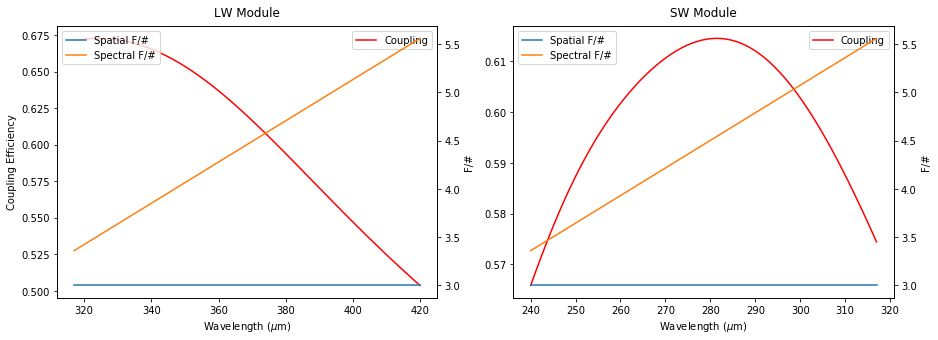

In [99]:
fig, (ax_LW, ax_SW) = plt.subplots(1,2,figsize=(15,5))
# instantiate a second axes that shares the same x-axis so we can plot F/#
ax_LW_Fnum = ax_LW.twinx();
ax_SW_Fnum = ax_SW.twinx();

ax_LW.plot(wavs_LW, coupling_LW, 'r', **{'label': 'Coupling'})
ax_SW.plot(wavs_SW, coupling_SW, 'r', **{'label': 'Coupling'})

ax_LW_Fnum.plot(wavs_LW, lw_fnum_spatial, **{'label': 'Spatial F/#'})
ax_LW_Fnum.plot(wavs_LW, lw_fnum_spectral, **{'label': 'Spectral F/#'})

ax_SW_Fnum.plot(wavs_SW, sw_fnum_spatial, **{'label': 'Spatial F/#'})
ax_SW_Fnum.plot(wavs_SW, sw_fnum_spectral, **{'label': 'Spectral F/#'})

ax_LW.set_xlabel(r'Wavelength ($\mu$m)')
ax_SW.set_xlabel(r'Wavelength ($\mu$m)')

ax_LW.set_ylabel('Coupling Efficiency')

ax_SW_Fnum.set_ylabel('F/#')
ax_LW_Fnum.set_ylabel('F/#')

ax_LW.set_title('LW Module')
ax_SW.set_title('SW Module')

ax_LW.legend();
ax_SW.legend();
ax_LW_Fnum.legend();
ax_SW_Fnum.legend();

### No Defocusing

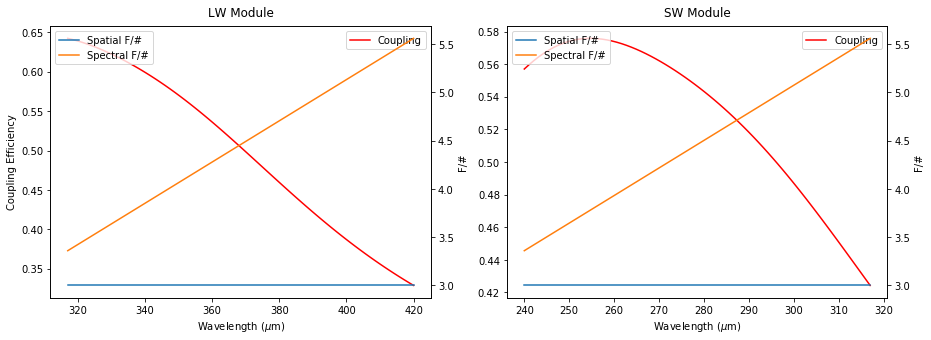

In [98]:
fig, (ax_LW, ax_SW) = plt.subplots(1,2,figsize=(15,5))
# instantiate a second axes that shares the same x-axis so we can plot F/#
ax_LW_Fnum = ax_LW.twinx();
ax_SW_Fnum = ax_SW.twinx();

ax_LW.plot(wavs_LW, coupling_LW, 'r', **{'label': 'Coupling'})
ax_SW.plot(wavs_SW, coupling_SW, 'r', **{'label': 'Coupling'})

ax_LW_Fnum.plot(wavs_LW, lw_fnum_spatial, **{'label': 'Spatial F/#'})
ax_LW_Fnum.plot(wavs_LW, lw_fnum_spectral, **{'label': 'Spectral F/#'})

ax_SW_Fnum.plot(wavs_SW, sw_fnum_spatial, **{'label': 'Spatial F/#'})
ax_SW_Fnum.plot(wavs_SW, sw_fnum_spectral, **{'label': 'Spectral F/#'})

ax_LW.set_xlabel(r'Wavelength ($\mu$m)')
ax_SW.set_xlabel(r'Wavelength ($\mu$m)')

ax_LW.set_ylabel('Coupling Efficiency')

ax_SW_Fnum.set_ylabel('F/#')
ax_LW_Fnum.set_ylabel('F/#')

ax_LW.set_title('LW Module')
ax_SW.set_title('SW Module')

ax_LW.legend();
ax_SW.legend();
ax_LW_Fnum.legend();
ax_SW_Fnum.legend();

### Read Zemax Data

In [3]:
# Filepath to the output data stored in a numpy array
filePath_OutPlane = 'TIM_OutOfPlane_ChromaticResData.npy'
filePath_InPlane = 'TIM_InPlane_ChromaticResData.npy'
# data is stored in a dictionary with the keys: 'SW' and 'LW', which are dictionaries, 
# each with keys, 'SFNO', 'TFNO', 'CENX', and 'CENY'. Each entry is a numpy array 
# whose rows are fields and columns are wavelegnths. The OutPlane data set has 100 x 400
# samples, while the InPlane data only has 25 x 72.
data_OutPlane = np.load(filePath_OutPlane).item()
data_InPlane = np.load(filePath_InPlane).item()

# F/#s
# Use the middle spatial field point to evaluate the F/#. There is some variation with 
# spatial position, but not significant.
(a_SW_InPlane, b_SW_InPlane) = fit_chromatic_res(SW1,SW2,f,data_InPlane['SW']['TFNO'][13],
                                                 data_InPlane['SW']['SFNO'][13],wavs_SW)

(a_SW_OutPlane, b_SW_OutPlane) = fit_chromatic_res(SW1,SW2,f,data_OutPlane['SW']['TFNO'][50],
                                                   data_OutPlane['SW']['SFNO'][50],wavs_SW)

(a_LW_InPlane, b_LW_InPlane) = fit_chromatic_res(LW1,LW2,f,data_InPlane['LW']['TFNO'][13],
                                                 data_InPlane['LW']['SFNO'][13],wavs_LW)

(a_LW_OutPlane, b_LW_OutPlane) = fit_chromatic_res(LW1,LW2,f,data_OutPlane['LW']['TFNO'][50],
                                                   data_OutPlane['LW']['SFNO'][50],wavs_LW)

### Plot Zemax Data

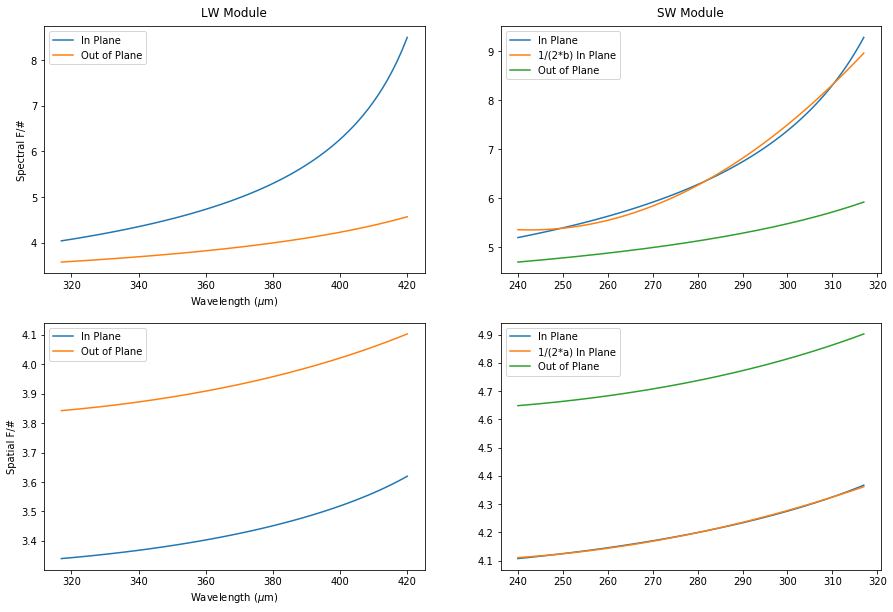

In [8]:
fig, ((ax_LW_S,ax_SW_S), (ax_LW_T,ax_SW_T)) = plt.subplots(2,2,figsize=(15,10))

ax_SW_S.set_title('SW Module')
ax_LW_S.set_title('LW Module')

ax_LW_T.set_xlabel(r'Wavelength ($\mu$m)')
ax_LW_S.set_xlabel(r'Wavelength ($\mu$m)')

ax_LW_S.set_ylabel('Spectral F/#')
ax_LW_T.set_ylabel('Spatial F/#')

ax_SW_T.plot(np.linspace(SW1,SW2,len(data_InPlane['SW']['TFNO'][13])),
             data_InPlane['SW']['TFNO'][13],**{'label': 'In Plane'})
ax_SW_T.plot(wavs_SW, 1/(2*a_SW_InPlane),**{'label': '1/(2*a) In Plane'})
ax_SW_T.plot(np.linspace(SW1,SW2,len(data_OutPlane['SW']['TFNO'][50])),
             data_OutPlane['SW']['TFNO'][50],**{'label': 'Out of Plane'})

ax_SW_S.plot(np.linspace(SW1,SW2,len(data_InPlane['SW']['SFNO'][13])),
             data_InPlane['SW']['SFNO'][13],**{'label': 'In Plane'})
ax_SW_S.plot(wavs_SW, 1/(2*b_SW_InPlane),**{'label': '1/(2*b) In Plane'})
ax_SW_S.plot(np.linspace(SW1,SW2,len(data_OutPlane['SW']['SFNO'][50])),
             data_OutPlane['SW']['SFNO'][50],**{'label': 'Out of Plane'})

ax_LW_T.plot(np.linspace(LW1,LW2,len(data_InPlane['LW']['TFNO'][13])),
             data_InPlane['LW']['TFNO'][13],**{'label': 'In Plane'})
ax_LW_T.plot(np.linspace(LW1,LW2,len(data_OutPlane['LW']['TFNO'][50])),
             data_OutPlane['LW']['TFNO'][50],**{'label': 'Out of Plane'})

ax_LW_S.plot(np.linspace(LW1,LW2,len(data_InPlane['LW']['SFNO'][13])),
             data_InPlane['LW']['SFNO'][13],**{'label': 'In Plane'})
ax_LW_S.plot(np.linspace(LW1,LW2,len(data_OutPlane['LW']['SFNO'][50])),
             data_OutPlane['LW']['SFNO'][50],**{'label': 'Out of Plane'})

ax_SW_T.legend()
ax_SW_S.legend()
ax_LW_T.legend()
ax_LW_S.legend();

### Zemax Coupling

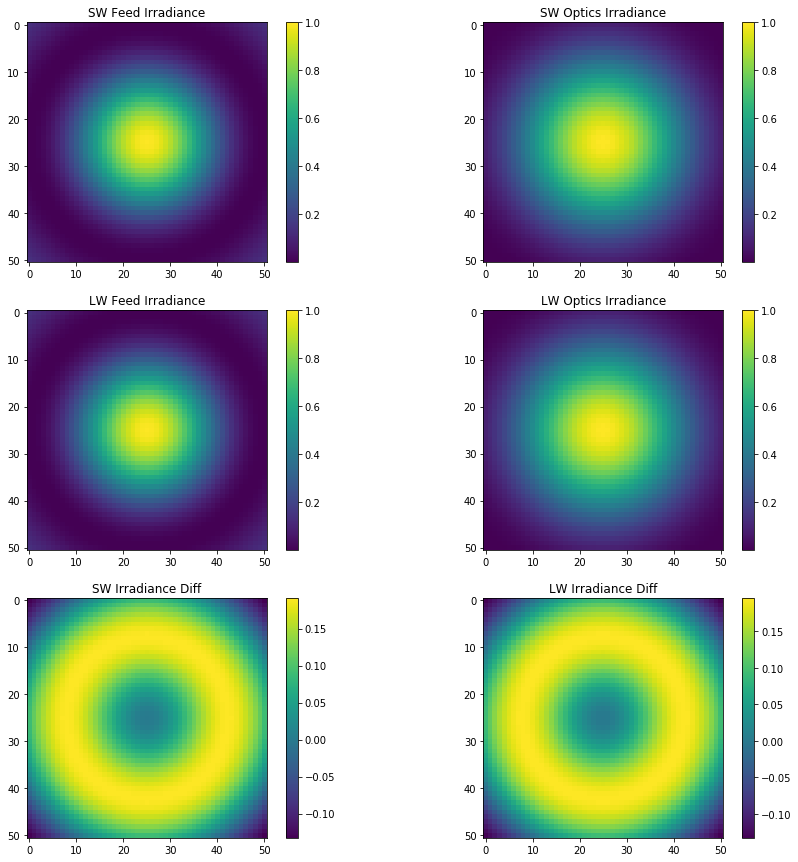

In [43]:
# Multiply fields, compute irradiance, compute power, normalize by power in corrugated feed field.
coupling_SW = {'InPlane': np.empty(numWavs), 'OutPlane': np.empty(numWavs)}
coupling_LW = {'InPlane': np.empty(numWavs), 'OutPlane': np.empty(numWavs)}
fig, ((ax_SW_feed, ax_SW_optics), (ax_LW_feed, ax_LW_optics), (ax_SW_diff, ax_LW_diff)) = plt.subplots(3,2,figsize=(15,15))
ax_SW_feed.set_title('SW Feed Irradiance')
ax_SW_optics.set_title('SW Optics Irradiance')
ax_SW_diff.set_title('SW Irradiance Diff')
ax_LW_feed.set_title('LW Feed Irradiance')
ax_LW_optics.set_title('LW Optics Irradiance')
ax_LW_diff.set_title('LW Irradiance Diff')

for w in range(numWavs):
    # Convert wavelength from microns to mm.
    feed_field = corrugated_feed_field(r,a,R,wavs_SW[w]/1000)
    optics_field = elliptical_diffract_field(X_ap,Y_ap,f,wavs_SW[w]/1000,a_SW_InPlane[w],b_SW_InPlane[w])
    coupling = np.sum(np.sum(optics_field*np.conj(feed_field)))/np.sqrt(np.sum(np.sum((optics_field*np.conj(optics_field))))
                                                                        *np.sum(np.sum((feed_field*np.conj(feed_field)))))
    coupling_SW['InPlane'][w] = (coupling*np.conj(coupling)).real
    
    # No need to recompute the feed field.
    optics_field = elliptical_diffract_field(X_ap,Y_ap,f,wavs_SW[w]/1000,a_SW_OutPlane[w],b_SW_OutPlane[w])
    coupling = np.sum(np.sum(optics_field*np.conj(feed_field)))/np.sqrt(np.sum(np.sum((optics_field*np.conj(optics_field))))
                                                                        *np.sum(np.sum((feed_field*np.conj(feed_field)))))
    coupling_SW['OutPlane'][w] = (coupling*np.conj(coupling)).real
    
    # Just plot one of the images to check.
    if w == 0:
        im = ax_SW_feed.imshow((feed_field*np.conj(feed_field)).real)
        fig.colorbar(im, ax=ax_SW_feed)
        im = ax_SW_optics.imshow((optics_field*np.conj(optics_field)).real)
        fig.colorbar(im, ax=ax_SW_optics)

        im = ax_SW_diff.imshow((optics_field*np.conj(optics_field) - feed_field*np.conj(feed_field)).real)
        fig.colorbar(im, ax=ax_SW_diff)
    
    # Recompute for the LW module.
    feed_field = corrugated_feed_field(r,a,R,wavs_LW[w]/1000)
    optics_field = elliptical_diffract_field(X_ap,Y_ap,f,wavs_LW[w]/1000,a_LW_InPlane[w],b_LW_InPlane[w])
    coupling = np.sum(np.sum(optics_field*np.conj(feed_field)))/np.sqrt(np.sum(np.sum((optics_field*np.conj(optics_field))))
                                                                        *np.sum(np.sum((feed_field*np.conj(feed_field)))))
    coupling_LW['InPlane'][w] = (coupling*np.conj(coupling)).real
    
    optics_field = elliptical_diffract_field(X_ap,Y_ap,f,wavs_LW[w]/1000,a_LW_OutPlane[w],b_LW_OutPlane[w])
    coupling = np.sum(np.sum(optics_field*np.conj(feed_field)))/np.sqrt(np.sum(np.sum((optics_field*np.conj(optics_field))))
                                                                        *np.sum(np.sum((feed_field*np.conj(feed_field)))))
    coupling_LW['OutPlane'][w] = (coupling*np.conj(coupling)).real
    
    if w == 0:
        im = ax_LW_feed.imshow((feed_field*np.conj(feed_field)).real)
        fig.colorbar(im, ax=ax_LW_feed)
        im = ax_LW_optics.imshow((optics_field*np.conj(optics_field)).real)
        fig.colorbar(im, ax=ax_LW_optics)

        im = ax_LW_diff.imshow((optics_field*np.conj(optics_field) - feed_field*np.conj(feed_field)).real)
        fig.colorbar(im, ax=ax_LW_diff)

In [40]:
print(coupling_LW['InPlane'][0])
print(coupling_SW['InPlane'][0])

0.806871142808363
0.7217637800946736


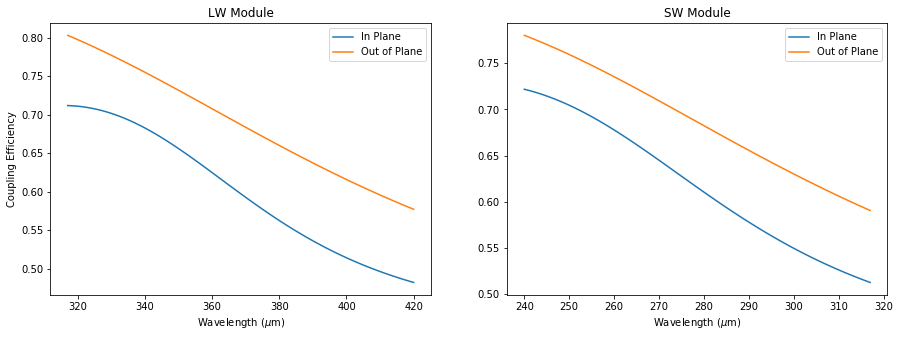

In [44]:
fig, (ax_LW, ax_SW) = plt.subplots(1,2,figsize=(15,5))
ax_LW.plot(wavs_LW, coupling_LW['InPlane'], **{'label': 'In Plane'})
ax_SW.plot(wavs_SW, coupling_SW['InPlane'], **{'label': 'In Plane'})
ax_LW.plot(wavs_LW, coupling_LW['OutPlane'], **{'label': 'Out of Plane'})
ax_SW.plot(wavs_SW, coupling_SW['OutPlane'], **{'label': 'Out of Plane'})

ax_LW.set_xlabel(r'Wavelength ($\mu$m)')
ax_SW.set_xlabel(r'Wavelength ($\mu$m)')

ax_LW.set_ylabel('Coupling Efficiency')

ax_LW.set_title('LW Module')
ax_SW.set_title('SW Module')

ax_LW.legend();
ax_SW.legend();